In [43]:
# import rasterio as rs
import xarray as xr
import numpy as np
# import cartopy.crs as ccrs
# import cartopy
import matplotlib.pyplot as plt
# import urllib
import glob
# import shutil
import geopandas
# import shapely
import rioxarray
from shapely.geometry import mapping
# import torch
# import time
import shutil

In [5]:
import os
os.mkdir('hi')

In [2]:
import zipfile

#      https://bearriverinfo.org/files-ou/dataset-downloads/brfromhuc12.zip
#      shapefile source

with zipfile.ZipFile('/home/albertl_uri_edu/scratch/bear_river/brfromhuc12.zip','r') as brshp:
    brshp.extractall('/home/albertl_uri_edu/scratch/bear_river/bearrivshp')

In [16]:
def clip2(raster,basin,basinname):
    rast = rioxarray.open_rasterio(raster,engine="rasterio")
    r_clip = rast.rio.clip(basin.geometry.apply(mapping),basin.crs)
    r_clip_nonans = np.where(r_clip[0]<0,np.nan,r_clip[0])
    # plt.imshow(r_clip_nonans)
    r_clip.to_netcdf(f'{basinname}_ssm/{basinname}_{raster[48:65]}.nc')
    r_clip_meta = xr.open_dataset(f'{basinname}_ssm/{basinname}_{raster[48:65]}.nc')
    r_clip_meta = r_clip_meta.rename({'__xarray_dataarray_variable__':'ssm'})
    #keep it to single lines for attributes
    r_clip_meta.attrs = {}
    r_clip_meta.attrs['surface_soil_moisture'] = "surface soil moisture" 
    r_clip_meta.attrs['ssm_units'] = "mm"
    r_clip_meta.attrs['ssm_source'] = "https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_SMAP10KM_soil_moisture#citations"
    r_clip_meta.to_netcdf(f'{basinname}_ssm/metadata/{basinname}_{raster[48:65]}.nc')
    return r_clip,r_clip_nonans

In [50]:
### invokes the function
###
### 
### 
### relatively slower because of more interations


basinname = 'bear_river'
os.mkdir(f'{basinname}_ssm')
os.mkdir(f'{basinname}_ssm/metadata')
basin = geopandas.read_file('/home/albertl_uri_edu/scratch/bear_river/bearrivshp/brfromhuc12.shp')
smap_ssm_tensor = glob.glob('../smap_files/smap_ssm_ee/tifs/*.tif')
for idx,raster in enumerate(smap_ssm_tensor):
    clip2(raster,basin,'bear_river')
delete = glob.glob('bear_river_ssm/*.nc')
for i in delete:
    os.remove(i)
move = glob.glob('bear_river_ssm/metadata/*.nc')
for i in move:
    shutil.move(i,'bear_river_ssm/')
os.rmdir('bear_river_ssm/metadata')

In [11]:
# smap_ssm_tensor = glob.glob('../smap_files/smap_ssm_ee/tifs/*.tif')
# smap_ssm_tensor[0][48:65] ### in case one needs to troubleshoot the naming structure of clip2
# basin = geopandas.read_file('yukonshp/11573.shp')

# clip2(smap_ssm_tensor[0],basin,'yukon');

# clipped_ssm = xr.open_dataset('smap_ee_yukon_ssm/metadata/yukon_20150402_20150404.nc')
# clipped_ssm

# plt.imshow(np.where((clipped_ssm.ssm>0) & (clipped_ssm.ssm<25.36) == True,clipped_ssm.ssm,np.nan)[0])
# plt.colorbar()

'20150402_20150404'

In [53]:
import torch
import time

def nc2torch(i):
    return torch.from_numpy(np.asarray(i)).unsqueeze(0)

# m = xr.open_dataset('smap_ee_miss_smp_metadata/miss_20190505_20190507.nc')
# w = xr.open_dataset('smap_ee_miss_smp_metadata/miss_20150402_20150404.nc')
# m1 = nc2torch(m.sm_profile)
# w1 = nc2torch(w.sm_profile)

x = glob.glob(f'{basinname}_ssm/*.nc')
print(len(x))
xx = xr.open_dataset(x[0])

# y = torch.load('ct_streamz.pt')
# print(y.shape)

dset = torch.empty([0,1,xx.y.shape[0],xx.x.shape[0]])
t2 = []

for x in sorted(glob.glob(f'{basinname}_ssm/*.nc')):
    t0 = time.time()
    y = xr.open_dataset(x)
    z = nc2torch(y.ssm)
    dset = torch.cat((dset,z))
    t1 = time.time()
    t2.append(t1-t0)
#     break
print(dset.shape)

torch.save(dset,f'{basinname}_ssm_imz.pt')

x = torch.load(f'{basinname}_ssm_imz.pt')
print(f'{basinname} images shape',x.shape)

841
torch.Size([841, 1, 22, 13])
bear_river images shape torch.Size([841, 1, 22, 13])


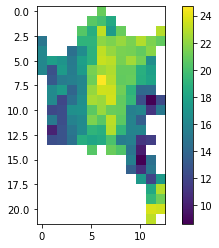

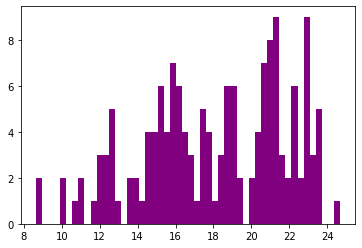

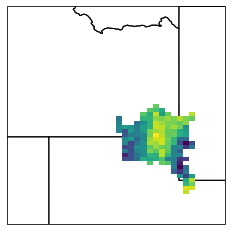

In [54]:
##plots sample
##of course you can look at all of them, create animation, etc from this point, too.

clipped_ssm = xr.open_dataset('bear_river_ssm/bear_river_20150402_20150404.nc')
clipped_ssm

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

lat,lon = np.meshgrid(clipped_ssm.y,clipped_ssm.x,indexing='ij')
ssm = np.where((clipped_ssm.ssm>0) & (clipped_ssm.ssm<25.36) == True,clipped_ssm.ssm,np.nan)[0]

plt.figure()
plt.imshow(ssm)
plt.colorbar()

plt.figure()
plt.hist(ssm.reshape(-1),bins=50,color='purple')

def main():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # make the map global rather than have it zoom in to
    # the extents of any plotted data
    ax.set_extent([-115, -110, 40, 45], crs=ccrs.PlateCarree())
#     ax.stock_img()
    ax.coastlines()
    ax.add_feature(cfeature.STATES)
    ax.pcolormesh(lon,lat,ssm)

    plt.show()


if __name__ == '__main__':
    main()

In [56]:
import torch
import numpy as np

# https://nwis.waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=09429600&referred_module=sw&period=&begin_date=2015-01-01&end_date=2022-02-26


y = []
with open(f'{basinname}_streamz.txt','r') as f:
    for x in f:
        y.append(x)
y = np.asarray(y)
print('number of lines in text file',y.shape)

streamflows = y[31:] #gets rid of meta data 
z = []
for idx,x in enumerate(streamflows):
    y = x.split('\t')
    z.append(y)

z = np.asarray(z)
a = np.expand_dims(np.asarray(['Gov Ent','Gage ID','Acq Date','cubic ft/s','unknown']),0)
b = np.vstack((a,z))
# b = b[:-5] #gets rid of dates we don't want
print(b[1],'\n',b[-1])
c = b[1:,3]
d = np.empty((0))
for x in c:
    try:
        d = np.append(d,float(x))
    except:
        print('+1 empty, replaced with -12345678')
        d = np.append(d,-12345678)


x = torch.Tensor([.333,.333,.333]).float()
x = x.unsqueeze(0).unsqueeze(0).unsqueeze(0)
y = torch.from_numpy(d).float().unsqueeze(0).unsqueeze(0).unsqueeze(0)

kernel_height = 1
kernel_width = 3
unfold = torch.nn.Unfold(kernel_size = (kernel_height,kernel_width),stride=(kernel_height,kernel_width))

#using x, you can control what range of days you want to start from
#y is based off of d which is based off of b
#it's streamflow in cubic feet / second
X = 91 #91 in this case is just ninety first in list starting in 2015
arr_unfold = unfold(y[:,:,:,X:]).permute(2,0,1).reshape(-1,1,kernel_height,kernel_width)
streamflow_3day = torch.FloatTensor([torch.mean(x) for x in arr_unfold])

#time column for reference
c = np.asarray(b[1:,2])
streamtime = c.copy()
time_idx = torch.arange(X,c.shape[0]).unsqueeze(0).unsqueeze(0).unsqueeze(0).float()

time_idx_unfold = unfold(time_idx).permute(2,0,1).reshape(-1,1,kernel_height,kernel_width)
dates_of_acquisition = []
for idx,x in enumerate(time_idx_unfold):
    y = f'{streamtime[int(x[0,0,0])]}_{streamtime[int(x[0,0,2])]}'
#     print(y)
    dates_of_acquisition.append(y)
#     print(streamtime[int(x[0,0,0])],'_',streamtime[int(x[0,0,2])])

streamflow_ship = np.transpose(np.vstack((np.expand_dims(dates_of_acquisition,0),np.expand_dims(streamflow_3day,0))))
streamflow_ship_txt = [str(x) for x in streamflow_ship]
print(streamflow_ship_txt[0])
# for idx,x in enumerate(streamflow_ship):
#     print(idx,x)
    
txt_file = open(f"streamflow_3day_{basinname}_for_neuralnet.txt","w")
for idx,x in enumerate(streamflow_ship_txt):
    txt_file.write(f'{idx} {x} \n')
txt_file.close()
print('CHECKPOINT!')

streamz = np.expand_dims(np.float32(streamflow_ship[:,1]),1)
streamz_tensor = torch.from_numpy(streamz).unsqueeze(1).unsqueeze(1)
torch.save(streamz_tensor,f'{basinname}_streamz.pt')

number of lines in text file (2645,)
['USGS' '10039500' '2015-01-01' '125' 'A:e\n'] 
 ['USGS' '10039500' '2022-02-26' 'Ice' 'P\n']
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced 